<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


Reading original data

In [3]:
PATH_TO_DATA = ('../../data')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

train_df.sample(frac=1).reset_index(drop=True)
y = train_df['target']
ratio = 0.9
idx = int(round(train_df.shape[0] * ratio))
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=17)
train_split = train_df.shape[0]

In [4]:
sum(y)

2297

In [5]:
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)
    sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])

In [6]:
sites_dict.head(5)

,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [7]:
X = pd.concat([train_df.drop(columns='target'), test_df], axis = 0)

In [8]:
X.shape

(336358, 20)

In [9]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]
X[times] = X[times].apply(pd.to_datetime)
X[sites] = X[sites].fillna(0).astype('int')
X['sites'] = X[sites].apply(lambda x: " ".join(x.astype('str')), axis = 1)

In [10]:
X['hour'] = X['time1'].apply(lambda x: x.hour)

In [11]:
X['month'] = X['time1'].apply(lambda x: x.month)

In [12]:
X['year'] = X['time1'].apply(lambda x: x.year)

In [13]:
X['yearmonth'] = 12*(X['year'] - 2013) + X['month']

In [14]:
X['hour1618'] = X['time1'].apply(lambda x: 16<=x.hour<=18).astype('int')

In [15]:
X['hour1213'] = X['time1'].apply(lambda x: 12<=x.hour<=13).astype('int')

In [16]:
X['hour915'] = X['time1'].apply(lambda x: (x.hour == 9 or x.hour == 15)).astype('int')

In [17]:
X['minute'] = X['time1'].apply(lambda x: x.minute)

In [18]:
X['len'] = (X['time10'] - X['time1']).apply(lambda x: np.log1p(x.total_seconds())).fillna(0)

In [19]:
X['hourminute'] = X['hour'] * 60 + X['minute']

In [20]:
X['weekday'] = X['time1'].apply(lambda x: x.weekday())

In [21]:
all_sites = " ".join(X[:train_split][y==1]['sites'].values);
all_sites = Counter(all_sites.split())
all_sites["0"] = 0

In [22]:
all_sites = " ".join(X[:train_split][y==1]['sites'].values);
all_sites = Counter(all_sites.split())
all_sites["0"] = 0

In [23]:
def get_most_common_sites(n=10):
    global all_sites
    return [el[0] for el in all_sites.most_common(n)]

In [24]:
get_most_common_sites(1)

['77']

In [25]:
def get_score(el):
    global all_sites
    valid_sites = [all_sites[x] for x in el.split() if x != '0']
    return sum(valid_sites) / len(valid_sites)

#X['count'] = X['sites'].apply(lambda x: sum([1 for el in x.split() if el != '0']))

X['score'] = X['sites'].apply(lambda x: get_score(x))

In [26]:
X['count'] = X['sites'].apply(lambda x: len(set(x.split())))

In [27]:
most_common_sites = set(get_most_common_sites(10))
X['most_common'] = X['sites'].apply(lambda x: len(set(x.split()) & most_common_sites) > 0).astype('int')

In [28]:
X.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,hour1618,hour1213,hour915,minute,len,hourminute,weekday,score,count,most_common
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,0,NaT,0,NaT,0,NaT,0,NaT,...,0,0,0,2,0.000000,602,3,0.0,2,0
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,...,0,0,0,19,3.295837,679,5,91.9,7,0
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,...,1,0,0,40,2.079442,1000,0,53.5,4,0
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,...,0,0,0,52,5.602119,652,4,0.0,1,0
5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 10:55:22,178,2014-02-28 10:55:23,177,2014-02-28 10:55:23,...,0,0,0,53,5.509388,653,4,65.9,4,1


In [29]:
features = ['hour1618', 'hour1213', 'hour915', 'len', 'weekday', 'hour']

In [30]:
full_sites = X[sites]
sites_flatten = full_sites.values.flatten()
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]
full_sites_sparse

<336358x48371 sparse matrix of type '<class 'numpy.int64'>'
	with 3195430 stored elements in Compressed Sparse Row format>

In [31]:
ohe = OneHotEncoder().fit_transform(X['hour'].reshape(-1, 1))

In [32]:
scaler = StandardScaler().fit_transform(X[['weekday']])

In [33]:
train_df = X[:train_split]
test_df = X[train_split:]

In [34]:
print(train_df.shape,test_df.shape)

(253561, 35) (82797, 35)


In [35]:
feature = ['month']

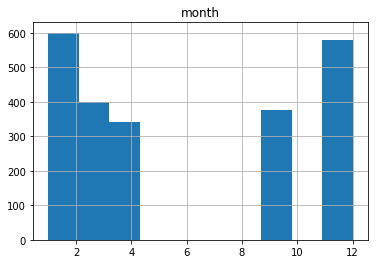

In [36]:
train_df[y==1][feature].hist();

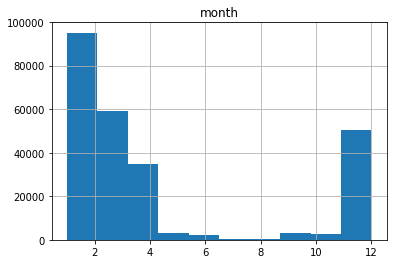

In [37]:
train_df[y==0][feature].hist();

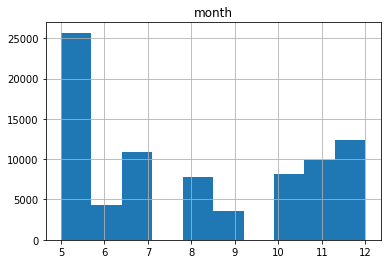

In [38]:
test_df[feature].hist();

Separate target feature 

In [39]:
train_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,hour1618,hour1213,hour915,minute,len,hourminute,weekday,score,count,most_common
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,0,NaT,0,NaT,0,NaT,0,NaT,...,0,0,0,2,0.000000,602,3,0.000000,2,0
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,...,0,0,0,19,3.295837,679,5,91.900000,7,0
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,...,1,0,0,40,2.079442,1000,0,53.500000,4,0
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,...,0,0,0,52,5.602119,652,4,0.000000,1,0
5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 10:55:22,178,2014-02-28 10:55:23,177,2014-02-28 10:55:23,...,0,0,0,53,5.509388,653,4,65.900000,4,1
6,570,2014-03-18 15:18:31,21,2014-03-18 15:18:39,570,2014-03-18 15:23:02,21,2014-03-18 15:23:43,21,2014-03-18 15:29:57,...,0,0,1,18,0.000000,918,1,514.200000,3,1
7,803,2014-02-13 16:45:35,23,2014-02-13 16:45:35,5956,2014-02-13 16:45:35,17513,2014-02-13 16:45:35,37,2014-02-13 16:46:05,...,1,0,0,45,4.634729,1005,3,158.700000,7,1
8,22,2013-04-12 10:27:26,21,2013-04-12 10:27:26,29,2013-04-12 10:27:28,5041,2013-04-12 10:27:29,14422,2013-04-12 10:27:29,...,0,0,0,27,1.945910,627,4,357.000000,7,1
9,668,2014-03-17 16:23:08,940,2014-03-17 16:23:35,942,2014-03-17 16:23:35,941,2014-03-17 16:23:35,941,2014-03-17 16:23:36,...,1,0,0,23,3.828641,983,0,271.600000,7,1


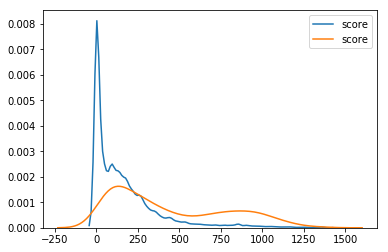

In [40]:
sns.kdeplot(train_df[y==0]['score'])
sns.kdeplot(train_df[y==1]['score'])

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [41]:
tf = TfidfVectorizer(ngram_range=(1,7), max_features = 200000)
tf.fit(train_df['sites'].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=200000, min_df=1,
        ngram_range=(1, 7), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [42]:
#full_sites_sparse, , ohe
full_df = hstack([tf.transform(X['sites']), X[features]], format='csr')
X_train = full_df[:train_split]
X_test = full_df[train_split:]

Scale this features and combine then with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

Perform cross-validation with logistic regression.

In [43]:
#params={'C': [0.1, 0.5, 1, 5,10,15,20,25,30]}
#logit = GridSearchCV(LogisticRegression(), params, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=10)
#logit.fit(X_train[:idx,:], y[:idx])

In [44]:
np.mean(cross_val_score(LogisticRegression(C=10), X_train, y, n_jobs=4, scoring='roc_auc', cv=skf))

0.9849491484422331

In [45]:
#y_pred = logit.predict_proba(X_train[idx:, :])[:, 1]
#roc_auc_score(y[idx:], y_pred)

NameError: name 'logit' is not defined

In [ ]:
#logit.best_params_

In [46]:
lr = LogisticRegressionCV(scoring = 'roc_auc', random_state=17, n_jobs=-1, cv=skf)
lr.fit(X_train[:idx, :], y[:idx])
y_pred = lr.predict_proba(X_train[idx:, :])[:, 1]
roc_auc_score(y[idx:], y_pred)

0.9861350578404517

In [47]:
sum(lr.predict(X_train))

1980

In [48]:
debug_df=train_df.copy()
debug_df['y'] = y
debug_df['y_score'] = lr.predict_proba(X_train)[:,1]
debug_df['y_pred'] = lr.predict(X_train)

In [ ]:
debug_df[(debug_df['y'] != debug_df['y_pred']) & (debug_df['hourminute'] > 600)].shape

(365, 38)

Make prediction for the test set and form a submission file.

In [ ]:
lr.fit(X_train, y)
test_pred = lr.predict_proba(X_test)[:, 1]
print(sum(lr.predict(X_test)))

In [ ]:
write_to_submission_file(test_pred, "assignment6_alice_submission.csv")